In [1]:
import hisepy
import os
import pandas as pd
import scanpy as sc

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read subclustering and barcode annotations from HISE

In [4]:
cell_class = 'nk-cells'

In [5]:
h5ad_uuid = 'b2a3d1ba-312d-41ec-9e51-8ef4c33192fe'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

downloading fileID: b2a3d1ba-312d-41ec-9e51-8ef4c33192fe
Files have been successfully downloaded!


In [7]:
anno_uuid = 'b57066f8-c0d5-4bfb-aa9b-79c743aa5886'

In [8]:
anno = read_parquet_uuid(anno_uuid)

downloading fileID: b57066f8-c0d5-4bfb-aa9b-79c743aa5886
Files have been successfully downloaded!


In [9]:
anno.head()

,barcodes,AIFI_L1,AIFI_L2,AIFI_L3
0,cf72d2f048b611ea8957bafe6d70929e,NK cell,CD56dim NK cell,GZMK+ CD56dim NK cell
1,cf73d29048b611ea8957bafe6d70929e,NK cell,NK+T Doublets,NK+T Doublets
2,cf73ecda48b611ea8957bafe6d70929e,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell
3,cf7430b448b611ea8957bafe6d70929e,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell
4,cf754e0448b611ea8957bafe6d70929e,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell


## Add annotations to barcodes

In [10]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = False)

In [11]:
adata.obs = obs

## Drop doublet/contamination labels

In [12]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [13]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [14]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [15]:
exclude_types

['NK+T Doublets',
 'CD56dim Mito+ NK',
 'NK+Platelet Doublet',
 'NK+Erythocytes Doublet']

In [16]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

In [17]:
adata = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata.shape

(143191, 1357)

## Plot L2 marker expression

In [19]:
l2_markers = [
    'FCGR3A', 'MKI67', 'NCAM1'
]

Set L2 category order

In [20]:
category_order = [
    'CD56bright NK cell',
    'CD56dim NK cell',
    'Proliferating NK cell'
]

adata.obs['AIFI_L2'] = (
    adata.obs['AIFI_L2']
    .cat
    .set_categories(category_order, ordered=True)
)

/tmp/ipykernel_3362/1653546302.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['AIFI_L2'] = (


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


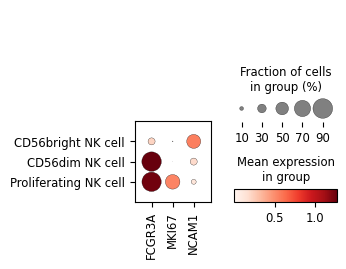

In [21]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L2',
    var_names = l2_markers,
    log = True
)

## Plot L3 marker expression

In [25]:
l3_markers = [
    'FCER1G', 'FCGR3A', 'GZMK', 'KLRC2', 'MKI67', 
    'MX1', 'NCAM1', 'ZBTB16'
]

Set L3 category order

In [26]:
category_order = [
    'CD56bright NK cell',
    'GZMK+ CD56dim NK cell',
    'Proliferating NK cell',
    'Adaptive NK cell',
    'GZMK- CD56dim NK cell',
    'ISG+ CD56dim NK cell'
]

adata.obs['AIFI_L3'] = (
    adata.obs['AIFI_L3']
    .cat
    .set_categories(category_order, ordered=True)
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


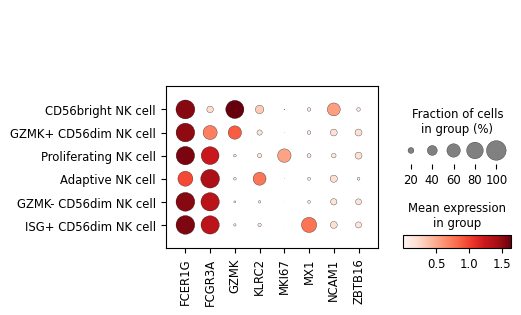

In [27]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = l3_markers,
    log = True
)

In [ ]:
import session_info
session_info.show()